# Sparkify Visualisation Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB).
Used to create seaborn and matplotlib graphs

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, udf, isnan, count, when, desc, sort_array, asc, avg, lag, floor
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.functions import sum as Fsum
import datetime

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("spark_capstone").getOrCreate()

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids. In this workspace, the filename is `mini_sparkify_event_data.json`.

In [3]:
data = spark.read.json("mini_sparkify_event_data.json")

In [4]:
df = data.where((data.userId != "") | (data.sessionId != ""))

In [5]:
churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
downgrade_churn = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())
df = df.withColumn("downgraded", downgrade_churn("page")).withColumn("cancelled", churn("page"))

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

downgrade_cancelled = df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled').drop('userId').toPandas()

ax = sns.boxplot(data=downgrade_cancelled)
ax = sns.swarmplot(data=downgrade_cancelled, ax=ax)
ax.set(title='Account Action Distribution', ylabel='Times Per User', xlabel='action');

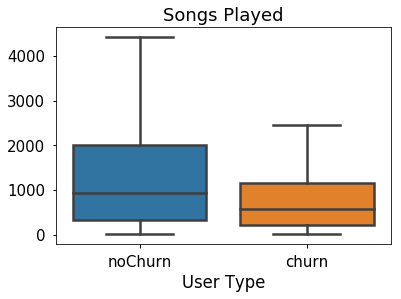

In [7]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
song=udf(lambda x : int(x=='NextSong'), IntegerType())
df = df.withColumn("churn_phase", Fsum("cancelled").over(windowval))\
    .withColumn("downgrade_phase", Fsum("downgraded").over(windowval))

song_play_pd = df.filter(col('churn_phase')==1).withColumn('songPlayed', song(col('page')))\
.groupBy('userId').count().toPandas()

song_play_0_pd = df.filter(col('churn_phase')==0).withColumn('songPlayed', song(col('page')))\
.groupBy('userId').count().toPandas()

song_play_0_pd.columns=['userId', 'noChurn']
song_play_pd.columns=['userId', 'churn']

ax = sns.boxplot(data=pd.concat([song_play_0_pd['noChurn'], song_play_pd['churn']], axis=1), showfliers=False)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax.set(xlabel='User Type', title='Songs Played');

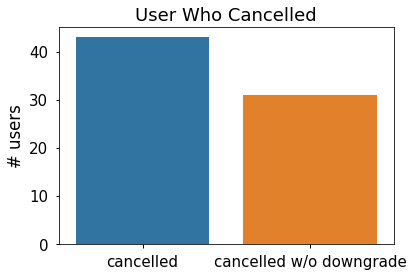

In [8]:
#number of users to cancel w/o downgrade
cancel = df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled')\
    .filter((col("downgraded")==0)&(col("cancelled")==1))\
    .count()
downgrade_paid = df.filter((col('cancelled')==1) & (col('downgraded')==0) & (col('level')=='paid'))\
      .select('userId').dropDuplicates().count()

ax = sns.barplot(data=pd.DataFrame({'cancelled':[cancel], 'cancelled w/o downgrade':[downgrade_paid]}))
ax.set(title='User Who Cancelled', ylabel='# users')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5});

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pca= [0.6684, 0.2304, 0.0372, 0.018, 0.0149, 0.01, 0.008, 0.0075, 0.0032, 0.0019, 0.0006, 0.0, 0.0]

In [9]:
pca_cs = np.cumsum(pca)
idx=np.arange(13)

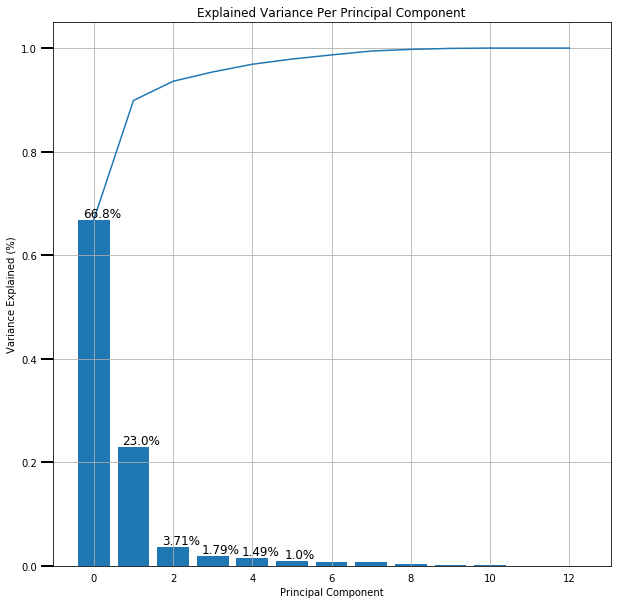

In [15]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.bar(idx, pca)
ax.plot(idx, pca_cs)
for i in range(13):
    if(i%20 == 0 or i<6):
        ax.annotate(r"%s%%" % ((str(pca[i]*100)[:4])), (idx[i]+0.2, pca[i]), va="bottom", ha="center", fontsize=12)

ax.xaxis.set_tick_params(width=0, gridOn=True)
ax.yaxis.set_tick_params(width=2, length=12, gridOn=True)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component');

In [39]:
def conf_mtx(mtx, title=None):
    '''
    [[TN, FN], [FP, TP]]
    '''
    
    if(title==None):
        title='Confusion Mtx'
        
    sns.set(font_scale=1.2)#for label size
    ax = sns.heatmap(mtx, annot=True,annot_kws={"size": 17}, fmt='g')
    ax.set(xlabel='Predicted Label', ylabel='True Label', title=title)
    plt.show()

In [33]:
conf_mtx_1 = [[1043, 279], [0, 0]]

In [ ]:
conf_mtx(conf_mtx_1, 'Logistic Regression Confusion Mtx')